In [1]:
import tensorflow as tf
import tensorflow.keras as keras

2024-07-08 08:19:02.939479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# test train splitting csv

import pandas as pd

df = pd.read_csv('train.csv')

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=28)

# val set
test_data, val_data = train_test_split(test_data, test_size=0.4, random_state=42)

In [3]:
#tfd
# function to convert dataframe to dataset

def df_dataset(dataframe, shuffle=True, batch_size = 32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset = df_dataset(train_data)
test_dataset = df_dataset(test_data, shuffle=False)

# creating an image dataset from value dataset

# dataset and dimensions
pixels = [ f'pixel{i}' for i in range(784) ]

columns = pixels +['label']

# preprocess

def preproc_fn(features, label):

    # extract pixel values
    img_pixels = [features[col] for col in pixels]

    # stack the pixels
    img_pixels = tf.stack(img_pixels, axis = 1)

    # reshape to 28*28
    img_pixels = tf.reshape(img_pixels, shape=[-1,28,28,1])

    # normalize
    img_pixels = tf.cast(img_pixels, tf.float32) / 255.0

    return img_pixels, label


test_dataset = test_dataset.map(preproc_fn)
train_dataset = train_dataset.map(preproc_fn)

# Debug function to print shapes
def print_shapes(features, label):
    tf.print("Features shape:", tf.shape(features))
    tf.print("Label shape:", tf.shape(label))
    return features, label

2024-07-08 08:19:37.913899: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# normal d

Y_train = train_data.pop('label')
Y_train = Y_train.astype(int)

X_train = train_data.astype(float)
X_train = X_train/255.0
X_train = X_train.values.reshape(-1,28,28,1)

Y_val = val_data.pop('label')
X_val = val_data.astype(float).values.reshape(-1,28,28,1)/255.0
Y_val = Y_val.astype(int)

Y_test = test_data.pop('label')
X_test = test_data.astype(float).values.reshape(-1,28,28,1)
Y_test = Y_test.astype(int)

In [5]:
# used 32 filters ,64

model = keras.Sequential([keras.layers.InputLayer(input_shape= (28,28, 1)), 
                          keras.layers.Conv2D(32,kernel_size=(6,6), activation ='relu', padding='same'), 
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(.25),
                          keras.layers.Conv2D(32,kernel_size=(6,6), activation ='relu', padding='same'), 
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(.3),
                          keras.layers.Conv2D(64,kernel_size=(3,3), activation ='relu', padding='same'), 
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(.25),
                          keras.layers.Conv2D(64,kernel_size=(3,3), activation ='relu', padding='same'), 
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(.33),
                          keras.layers.Flatten(), 
                          keras.layers.Dense(256, activation='relu'), 
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
Lrreducer = keras.callbacks.ReduceLROnPlateau(monitor= 'val_accuracy', 
                                              factor = 0.5, 
                                              mode= 'auto', 
                                              min_delta = 0.00001, 
                                              patience = 2,
                                              verbose=1,
                                              min_lr = 0.00001)

In [7]:
Imagegen = keras.preprocessing.image.ImageDataGenerator(rotation_range=10, 
                                                        width_shift_range=0.1, 
                                                        height_shift_range=0.1, 
                                                        zoom_range=0.1)

Imagegen.fit(X_train)

In [8]:
model.fit(Imagegen.flow(X_train, Y_train, batch_size=32), 
          validation_data = (X_val, Y_val), 
          callbacks = Lrreducer,
          verbose= 2,
          steps_per_epoch = X_train.shape[0],
          epochs = 2)

Epoch 1/2


2024-07-08 08:20:37.437517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


33600/33600 - 103s - loss: 0.7149 - accuracy: 0.7535 - val_loss: 0.1090 - val_accuracy: 0.9673 - lr: 0.0010 - 103s/epoch - 3ms/step


In [9]:
# Evaluate the model on the test dataset
test_loss, test_acc= model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc},Test Loss: {test_loss}")


158/158 [==============================] - 2s 13ms/step - loss: 17.0718 - accuracy: 0.9704
Test Accuracy: 0.9704365134239197,Test Loss: 17.07175064086914


2024-07-08 08:23:41.431474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_601' with dtype int64 and shape [5040]
	 [[{{node Placeholder/_601}}]]


1/1 [==============================] - 0s 108ms/step


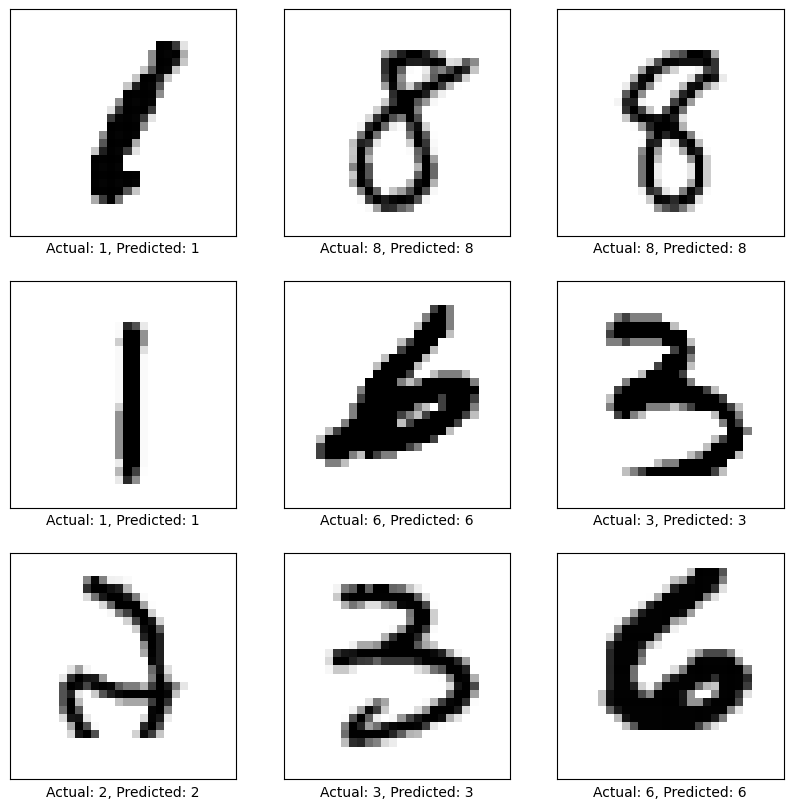

In [10]:
#tfd
# plotting actual with predicted along with images

import matplotlib.pyplot as plt

# Function to plot images with their predicted and actual labels
def plot_images(images, labels, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(f"Actual: {labels[i]}, Predicted: {predictions[i]}")
    plt.show()

# Visualize a batch of test images with their predictions
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    plot_images(images, labels, predicted_labels)

In [12]:
#making a submission predictions

predict_dataset = tf.data.experimental.make_csv_dataset('test.csv', 
                                                        batch_size=32, 
                                                        shuffle=False, 
                                                        num_epochs=1, 
                                                        column_names=pixels)


In [13]:
# preprocess to images

def preproc_fn2(features):

    # extract pixel values
    img_pixels = [features[col] for col in pixels]

    # stack the pixels
    img_pixels = tf.stack(img_pixels, axis = 1)

    # reshape to 28*28
    img_pixels = tf.reshape(img_pixels, shape=[-1,28,28,1])

    # normalize
    img_pixels = tf.cast(img_pixels, tf.float32) / 255.0

    return img_pixels

predict_dataset = predict_dataset.map(preproc_fn2)

# def print_shapes2(features):
#     tf.print("Features shape:", tf.shape(features))
#     return features


# predict_dataset = predict_dataset.map(print_shapes2)

predict_dataset = predict_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


2024-07-08 08:24:05.743109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_119' with dtype int32 and shape [1]
	 [[{{node Placeholder/_119}}]]
2024-07-08 08:24:05.756866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 26ms/step


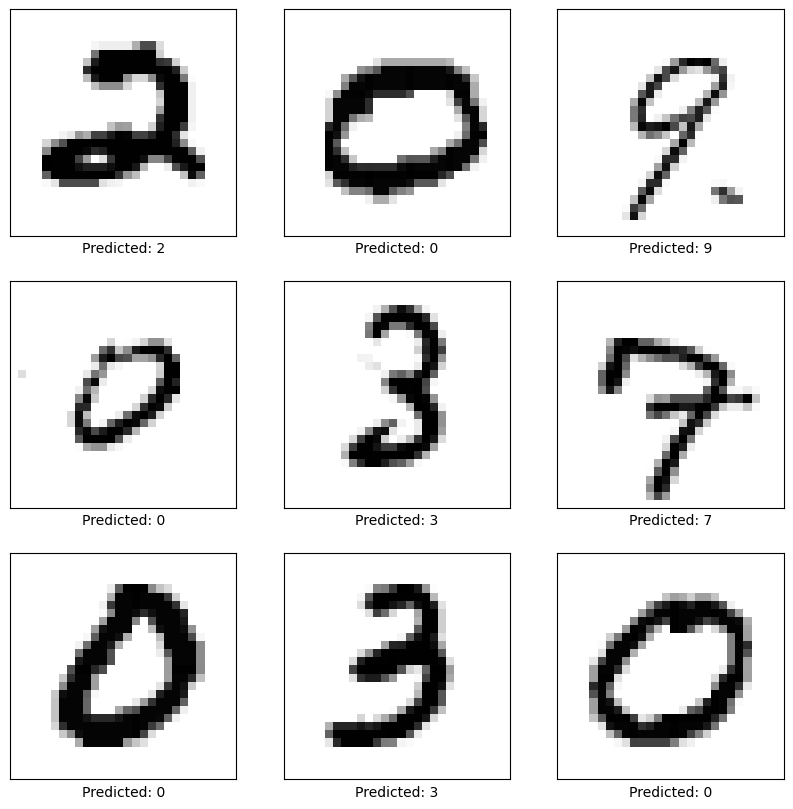

In [14]:
# plotting submission predictions along with images (first 10)
def plot_images(images, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(f"Predicted: {predictions[i]}")
    plt.show()


for images in predict_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    plot_images(images, predicted_labels)

In [15]:
predictions = model.predict(predict_dataset)
predicted_labels = tf.argmax(predictions, axis=1)

2024-07-08 08:24:10.687327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_754' with dtype int32 and shape [1]
	 [[{{node Placeholder/_754}}]]
2024-07-08 08:24:10.700886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_126' with dtype int32 and shape [1]
	 [[{{node Placeholder/_126}}]]


875/875 [==============================] - 30s 32ms/step


In [16]:
# getting submission file
df = pd.DataFrame({'ImageId': range(1,len(predicted_labels)+1), 'Label':predicted_labels})

df.to_csv('submission.csv', index=False)